### Imports

In [ ]:
!pip install pyshp
!pip install haversine
!pip install geopandas
!pip install pygeos

In [ ]:
!sudo apt install libspatialindex-dev

In [ ]:
!pip install Rtree

In [ ]:
# Imports
import pandas as pd
import numpy as np
import urllib.request
import zipfile
import random
import itertools
import math
from tqdm import tqdm
import time
from datetime import datetime
import timeit
import gc

# libraries to visualize data
import shapefile
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# Access to a database to operate on big data
import sqlalchemy
from sqlalchemy import create_engine
nyc_database = create_engine('sqlite:///nyc_database.db')

# compute additional features
from haversine import haversine
from pandas import DataFrame
from numba import njit
from math import radians, cos, sin, asin, sqrt


# Pre-Processing Pipeline

## Import the dataset into the database

In [ ]:
# Insert datasets to the db
# Insert datasets from january to ....
months = 2
j, chunksize = 1, 100000
for month in range(1,months):
    fp = "/Users/AAAA/Desktop/Datasets/NYC_2013/trip_data_{0}.csv".format(month)
    for df in pd.read_csv(fp, chunksize=chunksize, iterator=True):
        df = df.rename(columns={c: c.replace(' ', '_') for c in df.columns})
        df['pickup_hour'] = [x[11:16] for x in df['pickup_datetime']]
        df['dropoff_hour'] = [x[11:16] for x in df['dropoff_datetime']]
        df['pickup_date'] = [x[0:11] for x in df['pickup_datetime']]
        df['dropoff_date'] = [x[0:11] for x in df['dropoff_datetime']]
        df.drop(['vendor_id', 'rate_code', 'store_and_fwd_flag', 'trip_time_in_secs'], axis=1, inplace=True)
        df.index += j
        df.to_sql('trip_record', nyc_database, if_exists='append')
        j = df.index[-1] + 1
del df

In [ ]:
# If we have some problem, just drop the table

#DROP TABLE
#pd.read_sql_query('DROP TABLE IF EXISTS trip_record', nyc_database)

In [ ]:
# Total number of records
number = pd.read_sql_query('SELECT count(*) as number FROM trip_record', nyc_database)
print("Total number of records: ", number['number'][0])

## Find invalid records

In [ ]:
# Helper values to define validity

# Find the outliers
min_lat= 40.5774
max_lat= 40.9176
min_long= -74.15
max_long= -73.7004

# valid area (bounding box around the states)
min_lat= 38.8472
max_lat= 45.0153
min_long= -80.5243
max_long= -71.7517


# Dates in years in the past or in the future
upper = '2013-12-31 23:59:59'
lower = '2013-01-01 00:00:00'

# Logic operators
OR = ' OR '
AND = ' AND '
NOT = 'NOT '

In [ ]:
# Records with null coordinates
c1 = ( '((pickup_latitude IS NULL OR dropoff_latitude IS NULL) OR ' + 
         '(pickup_longitude IS NULL OR dropoff_longitude IS NULL))')

# Records with Coordinates out of range
c3 = ('((dropoff_longitude NOT BETWEEN :min_long AND :max_long ) OR '+
         '(dropoff_latitude NOT BETWEEN :min_lat AND :max_lat)) OR '+
      '((pickup_longitude NOT BETWEEN  :min_long AND :max_long ) OR '+
         '(pickup_latitude NOT BETWEEN  :min_lat AND :max_lat))')

# Records with pickup coordinates equal to dropoff
c2 = ('((pickup_latitude = dropoff_latitude) AND ' +
         '(pickup_longitude = dropoff_longitude ))')

# Records with distance 0
c4 = '(trip_distance <= 0.1)'

# Records with pickup time equal or greater than dropoff time
c5_7_9_10 = '(pickup_datetime >= dropoff_datetime)'

# Records with dates in years in the past or in the future
c6 = ('((pickup_datetime > :upper OR pickup_datetime < :lower ) OR (dropoff_datetime > :upper OR dropoff_datetime < :lower ))')

# Records with zero or null passengers
c8 = '(passenger_count < 1 OR passenger_count IS null OR passenger_count > 6)'

# null datetimes
c9 = '(pickup_datetime IS NULL OR dropoff_datetime IS NULL)'

not_where_clause = '(' + c1 + OR + c3 + OR + c2 + OR + c5_7_9_10 + OR + c6+ OR + c8 + OR + c9 +')'
# count invalid rows
query = ('SELECT count(*) as number FROM trip_record WHERE '+ not_where_clause) # c1 + OR + c3 + OR + c2 + OR + c5_7_9_10 + OR + c6  
res = pd.read_sql_query( query, nyc_database, params={"min_long":min_long, "max_long":max_long, "min_lat":min_lat, "max_lat":max_lat, "upper":upper, "lower":lower})
invalid = res['number'][0]
print('Number of invalid rows: ', invalid)

Number of invalid rows:  460953


## Find valid records

In [ ]:
# Records with not null coordinates
c1 = ( '((pickup_latitude IS NOT NULL AND dropoff_latitude IS NOT NULL) AND ' + 
         '(pickup_longitude IS NOT NULL AND dropoff_longitude IS NOT NULL))')

# Records with coordinates in the range
c3 = ('((dropoff_longitude BETWEEN :min_long AND :max_long ) AND '+
         '(dropoff_latitude BETWEEN :min_lat AND :max_lat) AND '+
      '(pickup_longitude BETWEEN :min_long AND :max_long ) AND '+
         '(pickup_latitude BETWEEN :min_lat AND :max_lat))')

# Records with pickup coordinates not equal to dropoff
c2 = ('((pickup_latitude != dropoff_latitude) OR ' +
         '(pickup_longitude != dropoff_longitude ))')

# Records with different coordinates but distance greater 0
c4 = '(trip_distance > 0.1)'

# Records with pickup time smaller than dropoff time
c5_7_9_10 = '(pickup_datetime < dropoff_datetime)'

# Records with dates in the right range
c6 = ('((pickup_datetime <= :upper AND pickup_datetime >= :lower ) AND (dropoff_datetime <= :upper AND dropoff_datetime >= :lower ))')

# Not Zero passengers and passenger count in range
c8 = '((passenger_count BETWEEN 1 AND 6) AND passenger_count IS NOT null )'

# not null datetimes
c9 = '(pickup_datetime IS NOT NULL AND dropoff_datetime IS NOT NULL)'

where_clause = '(' + c1 + AND + c3 + AND + c2 + AND + c5_7_9_10 + AND + c6 + AND + c8 + AND + c9 + ')'


In [ ]:

query = ('SELECT count(*) as number FROM trip_record WHERE '+where_clause ) # c1 + AND + c3 + AND + c2 + AND + c5_7_9_10 + AND + c6
res = pd.read_sql_query( query, nyc_database, params={"min_long":min_long, "max_long":max_long, "min_lat":min_lat, "max_lat":max_lat, "upper":upper, "lower":lower})
valid = res['number'][0]
print('Number of valid rows: ', valid)

# to check if number is correct
#print( 'Tot: ', valid + invalid)
#print( 'Error: ', 14776615 - (valid + invalid))

Number of valid rows:  14315662


### Retrieve valid records

In [ ]:
#TODO: Remov the limit
query = ('SELECT *  FROM trip_record WHERE '+ where_clause + ' LIMIT 1000') #+ ' LIMIT 1000000'
valid_records = pd.read_sql_query( query, nyc_database, params={"min_long":min_long, "max_long":max_long, "min_lat":min_lat, "max_lat":max_lat, "upper":upper, "lower":lower})

In [ ]:
valid_records.shape 

,index,medallion,hack_license,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_hour,dropoff_hour,pickup_date,dropoff_date
0,1,89D227B655E5C82AECF13C3F540D4CF4,BA96DE419E711691B9445D6A6307C170,2013-01-01 15:11:48,2013-01-01 15:18:10,4,1.00,-73.978165,40.757977,-73.989838,40.751171,15:11,15:18,2013-01-01,2013-01-01
1,2,0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,2013-01-06 00:18:35,2013-01-06 00:22:54,1,1.50,-74.006683,40.731781,-73.994499,40.750660,00:18,00:22,2013-01-06,2013-01-06
2,3,0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,2013-01-05 18:49:41,2013-01-05 18:54:23,1,1.10,-74.004707,40.737770,-74.009834,40.726002,18:49,18:54,2013-01-05,2013-01-05
3,4,DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,2013-01-07 23:54:15,2013-01-07 23:58:20,2,0.70,-73.974602,40.759945,-73.984734,40.759388,23:54,23:58,2013-01-07,2013-01-07
4,5,DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,2013-01-07 23:25:03,2013-01-07 23:34:24,1,2.10,-73.976250,40.748528,-74.002586,40.747868,23:25,23:34,2013-01-07,2013-01-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1029,0E0569377FEAE2A65216459409656B05,754D328E223D507A668F0B94C0479904,2013-01-13 10:26:00,2013-01-13 10:34:00,5,1.73,-73.982452,40.723309,-73.986374,40.740303,10:26,10:34,2013-01-13,2013-01-13
996,1030,9AE4E5913011D9842C31F8D120697F5B,191F9FA1FCB4C083E571CE62418037B7,2013-01-13 10:05:00,2013-01-13 10:34:00,1,18.87,-73.804657,40.650089,-73.966782,40.799061,10:05,10:34,2013-01-13,2013-01-13
997,1031,8E38C50BAA33C67E44678D7D18B87B54,4E3AA1185615CEED03BB1DC7A94030D0,2013-01-13 10:22:00,2013-01-13 10:32:00,5,3.06,-73.982697,40.723381,-74.008392,40.707542,10:22,10:32,2013-01-13,2013-01-13
998,1032,149298F6D390FA640E80B41ED31199C5,2B02144C5BAC85D9AF16620B55189491,2013-01-13 10:13:00,2013-01-13 10:30:00,2,3.13,-73.978477,40.746571,-74.010750,40.718456,10:13,10:30,2013-01-13,2013-01-13


Read the records in the valid area chunk by chunk to avoid memory overflow

In [ ]:
import pandas.io.sql as psql

chunk_size = 5000000
offset = 0
dfs = []
header = True
while True:
  print(offset)
  sql = "SELECT * FROM trip_record WHERE " + where_clause + " ORDER BY pickup_longitude LIMIT %d offset %d " % (chunk_size,offset) 
  df = pd.read_sql_query( sql, nyc_database, params={"min_long":min_long, "max_long":max_long, "min_lat":min_lat, "max_lat":max_lat, "upper":upper, "lower":lower})
  print('Query done')
  df.to_csv('/home/alex/Downloads/january.csv', header=header, mode='a')

  

  header = False
  offset += chunk_size
  if len(df) < chunk_size:
    break
  del df
  gc.collect()


0
Query done
5000000
Query done
10000000
Query done


In [ ]:
  # Empty space in the memory
  del df
  gc.collect()

1643

In [ ]:
# Save the partial result
df = pd.read_csv('/home/AAAA/Downloads/january.csv')

### Google Drive version

In [ ]:
!pip install pyshp
!pip install haversine
!pip install geopandas
!pip install pygeos

!sudo apt install libspatialindex-dev

!pip install Rtree

# Imports
import pandas as pd
import numpy as np
import urllib.request
import zipfile
import random
import itertools
import math
from tqdm import tqdm
import time
from datetime import datetime
import timeit

# libraries to visualize data
import shapefile
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline


# compute additional features
from haversine import haversine
from pandas import DataFrame
from numba import njit
from math import radians, cos, sin, asin, sqrt

from google.colab import drive
drive.mount('/content/gdrive')
baseURL = '/content/gdrive/My Drive/NYC Dataset/';
directory = baseURL


In [ ]:
dtypes = {'Unnamed: 0':'str',	'index':'str',	'medallion':'str',	'hack_license':'str',	'pickup_datetime':'str',	'dropoff_datetime':'str',	'passenger_count':'str',	'trip_distance':'str',
          'pickup_longitude':'str',	'pickup_latitude':'str',	'dropoff_longitude':'str',	'dropoff_latitude':'str',	'pickup_hour':'str',	'dropoff_hour':'str',	'pickup_date':'str',	'dropoff_date':'str'}
usecols=['medallion',	'hack_license',	'pickup_datetime',	'dropoff_datetime',	'passenger_count',	'trip_distance',
          'pickup_longitude',	'pickup_latitude',	'dropoff_longitude',	'dropoff_latitude',	'pickup_hour',	'dropoff_hour',	'pickup_date',	'dropoff_date']

valid_records = pd.read_csv(baseURL + 'january.csv', usecols=['medallion',	'hack_license',	'pickup_datetime',	'dropoff_datetime',
          'pickup_longitude',	'pickup_latitude',	'dropoff_longitude',	'dropoff_latitude'], skiprows=5000001)

In [ ]:
valid_records.head()

,medallion,hack_license,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,E7895290D325C76879B42DD851F55E94,F1DE3C76634E6A28F773E373FD93A4CC,2013-01-25 23:22:00,2013-01-25 23:35:00,-80.466667,40.764290,-73.976265,40.744209
1,057CFB402254395B4EE4CC11F10474CF,F8183DA465EB5C606FBB4642E9D0E90B,2013-01-23 21:04:00,2013-01-23 21:14:00,-80.400002,40.751690,-73.977974,40.778862
2,7B08E3F1470250DC951EC734C23B28A8,F9CCB542EEF0627ED1F326DB70918A97,2013-01-26 08:29:00,2013-01-26 08:40:00,-80.383331,40.728111,-73.993317,40.696854
3,B7AF7D33EC1A1F20A1BD34EBC94AFAEA,46CA16E8B77FE2899F50347542068244,2013-01-12 18:11:00,2013-01-12 18:16:00,-80.383331,40.763401,-73.951187,40.783516
4,78A0CCB71F0CD7541B2FF8BC206DC358,5ECA0DEC91DF424D1AF995C49E1DA631,2013-01-20 11:24:00,2013-01-20 11:28:00,-80.349998,40.784885,-73.942993,40.777473


## Elaborate the data
Computing extra features to clean the dataset

Helper functions

In [ ]:
from haversine import haversine
from datetime import datetime
from pandas import DataFrame
import math
import numpy as np

In [ ]:
# https://www.kaggle.com/kartikkannapur/nyc-taxi-trips-exploratory-data-analysis
# compute haversine distance of a trip
# *The haversine formula determines the great-circle distance between two points on a sphere given their longitudes and latitudes.*

**Moving to numba to improve performances**

https://stackoverflow.com/questions/52673285/performance-of-pandas-apply-vs-np-vectorize-to-create-new-column-from-existing-c

In [ ]:
from numba import njit

# fix problematic times and conver time into hours
@njit
def refine_time(time_difference):
  res = np.empty(time_difference.shape)
  for i in range(len(time_difference)):
    duration_hours = time_difference[i]/3600.0
    if duration_hours < 0.005:
      trip_time = 0.005
    else:
      trip_time = round(duration_hours, 3)
    res[i] = trip_time
  return res



---
Duration of the trips


In [ ]:
valid_records["pickup_datetime"] = pd.to_datetime(valid_records["pickup_datetime"])
valid_records["dropoff_datetime"] = pd.to_datetime(valid_records["dropoff_datetime"])
valid_records['trip_time'] = (valid_records['dropoff_datetime'] - valid_records['pickup_datetime']).dt.total_seconds()
#%timeit valid_records['seconds'] = refine_time(valid_records['seconds'].values)
#print(refine_time(valid_records['seconds'].values))
valid_records['trip_time'] = refine_time(valid_records['trip_time'].values)
valid_records['trip_time']

8896484     0.136
13356912    0.324
8110791     0.106
11554091    0.205
12509246    0.579
            ...  
859749      0.217
4962148     0.100
2241584     0.050
1608444     0.433
4490083     0.183
Name: trip_time, Length: 14315662, dtype: float64

**%timeit in front a that function cause problem, the values returned become all 0.005**



---
Haversine Distance of the trips

https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas


In [ ]:
from math import radians, cos, sin, asin, sqrt
def haversine_np( lat1, lon1, lat2, lon2):
    # earth radius
    R = 6371.0
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = R * c
    return np.round(km, 3)

In [ ]:
valid_records['haversine_distance'] = haversine_np(valid_records["pickup_latitude"], valid_records["pickup_longitude"], 
                     valid_records["dropoff_latitude"], valid_records["dropoff_longitude"])

In [ ]:
valid_records['haversine_distance']

0           546.579
1           540.738
2           538.474
3           541.519
4           539.337
             ...   
14315657    169.311
14315658    174.901
14315659    187.634
14315660    393.620
14315661    181.982
Name: haversine_distance, Length: 14315662, dtype: float64



---
Speed of the trips


In [ ]:
valid_records['speed'] = round(valid_records['haversine_distance']/valid_records['trip_time'], 1)
valid_records['speed']

8896484     26.6
13356912     7.9
8110791     14.8
11554091    16.0
12509246    17.1
            ... 
859749      12.7
4962148     16.6
2241584     16.4
1608444     19.5
4490083     19.5
Name: speed, Length: 14315662, dtype: float64

## Statistics on valid records

### Number of passengers

In [ ]:
mean_p = valid_records["passenger_count"].mean()
max_p = valid_records["passenger_count"].max()
min_p = valid_records["passenger_count"].min()

print("The mean number of passengers is: ", mean_p)
print("The max number of passengers is: ", max_p)
print("The min number of passengers is: ", min_p)


The mean number of passengers is:  1.697404423211445
The max number of passengers is:  6
The min number of passengers is:  1


### Compute mean, min and max ***trip distance***


In [ ]:
mean_d = valid_records["haversine_distance"].mean()
max_d = valid_records["haversine_distance"].max()
min_d = valid_records["haversine_distance"].min()

print("The mean distance is: ", mean_d)
print("The max distance is: ", max_d)
print("The min distance is: ", min_d)
print("The distances are represented in Km unit")

The mean distance is:  3.2905488564901844
The max distance is:  580.425
The min distance is:  0.0
The distances are represented in Km unit


### Compute mean, min and max ***trip time***


In [ ]:
mean_t = valid_records["trip_time"].mean()
max_t = valid_records["trip_time"].max()
min_t = valid_records["trip_time"].min()

print("The mean trip_time is: ", mean_t)
print("The max trip_time is: ", max_t)
print("The min trip_time is: ", min_t)
print("The trip_times are represented in hours")

The mean trip_time is:  0.19142729920558352
The max trip_time is:  51.015
The min trip_time is:  0.005
The trip_times are represented in hours


### Compute mean, min and max ***speed***

In [ ]:
mean_speed = valid_records["speed"].mean()
max_speed = valid_records["speed"].max()
min_speed = valid_records["speed"].min()

print("The mean speed is: ", mean_speed)
print("The max speed is: ", max_speed)
print("The min speed is: ", min_speed)

The mean speed is:  16.79092
The max speed is:  216.7
The min speed is:  0.0


records:  100000


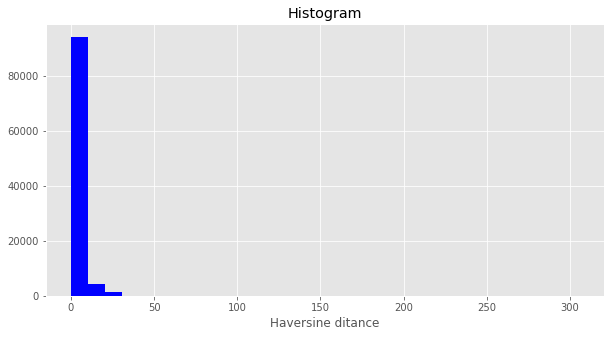

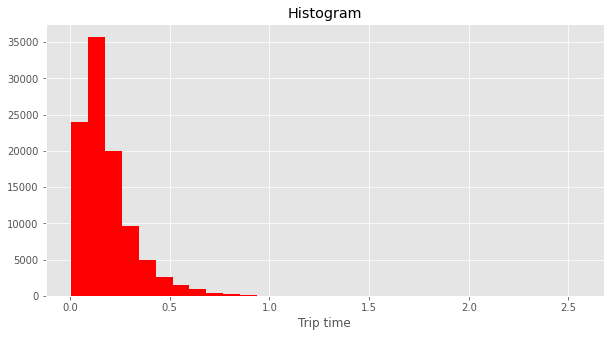

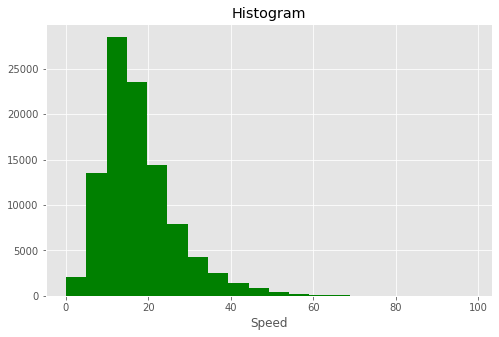

In [ ]:
# because haversine distance is the semicircle on  the sphere which connect 2 points, in reality the distance between A and B is greater, 
# so the real speed is higher than the one computed with haversine

print("records: ", len(valid_records.medallion))
valid_records.haversine_distance.hist(bins=30, figsize=(10,5), color = 'blue')
plt.xlabel('Haversine ditance')
plt.title('Histogram');
plt.show() 

valid_records.trip_time[valid_records.trip_time<8].hist(bins=30, figsize=(10,5), color = 'red')
plt.xlabel('Trip time')
plt.title('Histogram');
plt.show() 

valid_records.speed[valid_records.speed<100].hist(bins=20, figsize=(8,5), color = 'green')
plt.xlabel('Speed')
plt.title('Histogram');

## Statistics to find correct speed, time and distance ranges

Time
distance
speed

https://medium.com/datadriveninvestor/finding-outliers-in-dataset-using-python-efc3fce6ce32


step 1:
* Arrange the data in increasing order
* Calculate first(q1) and third quartile(q3)
* Find interquartile range (q3-q1)
* Find lower bound q1*1.5
* Find upper bound q3*1.5
* Anything that lies outside of lower and upper bound is an outlier


In [ ]:
from scipy import stats
# Haversine distance
distances = np.array(valid_records.sort_values(by=['haversine_distance']).haversine_distance)
q1, q3= np.percentile(distances,[25,75])
iqr = q3 - q1
lower_bound = q1 - (1.5 * iqr) 
upper_bound = q3 + (1.5 * iqr) 
print("IQR")
print("Lower bound: {}, Upper bound: {}".format(lower_bound,upper_bound))

IQR
Lower bound: -2.63, Upper bound: 7.698


Try with the Z score

In [ ]:
#distances = np.array(valid_records.sort_values(by=['haversine_distance']).haversine_distance)
z = np.abs(stats.zscore(distances))
threshold = 3
idx = np.where(z > threshold)
lower_bound = distances[idx].min()
upper_bound = distances[idx].max()
print("Z-score")
print("Upper bound from: {}, to: {}".format(lower_bound,upper_bound))

idx = np.where(z < -threshold)
if(len(idx[0]) >0):
  distances[idx].max()

Z-score
Upper bound from: 15.544, to: 580.425


Trip time

In [ ]:
times = np.array(valid_records.sort_values(by=['trip_time']).trip_time)
q1, q3= np.percentile(times,[25,75])
iqr = q3 - q1
lower_bound = q1 -(1.5 * iqr) 
upper_bound = q3 +(1.5 * iqr) 
print("IQR")
print("Lower bound: {}, Upper bound: {}".format(lower_bound,upper_bound))
print("")
# Z score
z = np.abs(stats.zscore(times))
threshold = 3
idx = np.where(z > threshold)
lower_bound = times[idx].min()
upper_bound = times[idx].max()
print("Z-score")
print("Upper bound from: {}, to: {}".format(lower_bound,upper_bound))

idx = np.where(z < -threshold)
if(len(idx[0]) >0):
  times[idx].max()

IQR
Lower bound: -0.12199999999999997, Upper bound: 0.47

Z-score
Upper bound from: 0.625, to: 51.015


Looking at the trips with triptime greater than 22 hours they seems weird. The number of these records is very low so we can remove them

In [ ]:
valid_records.loc[valid_records['trip_time']>22.0]

,index,medallion,hack_license,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_hour,dropoff_hour,pickup_date,dropoff_date,trip_time,haversine_distance,speed
4440189,108078988,D6CE961B1FD2F1A9E7F2F4A2262A9DDB,5101210B73A0E033D1509B3E487C929C,2013-01-01 05:35:12,2013-01-02 06:21:33,1,63.2,-73.981781,40.757675,-73.923630,40.743526,05:35,06:21,2013-01-01,2013-01-02,24.772,5.145,0.2
5960817,195249269,BB73239609D520BBAB248020103AEEC6,CD969521B4652E0473472E2A997910B5,2013-01-01 06:19:15,2013-01-02 07:15:20,1,6.0,-73.906479,40.727551,-73.923340,40.734325,06:19,07:15,2013-01-01,2013-01-02,24.935,1.608,0.1
6899824,262717006,5E7022BA90EE0AFE3A29ED664C609F7D,B0E1CAF7CED1FDB6C565A28B9228944F,2013-01-01 01:01:15,2013-01-02 07:16:35,1,3.1,-73.966850,40.772388,-73.918274,40.840519,01:01,07:16,2013-01-01,2013-01-02,30.256,8.609,0.3
7008535,270028968,4BE667AF6BA4B0A6F4F63C865CD84EA6,CDBEB1B3C2058DEE1DFEBAF0FEB26303,2013-01-15 02:24:26,2013-01-17 05:25:20,1,3.2,-73.978653,40.745186,-73.952026,40.750340,02:24,05:25,2013-01-15,2013-01-17,51.015,2.315,0.0
7503387,308038703,001D3B86C2ACDEE4D1B98AFE52969F3D,F617CC84C553584DAE13E96665FCBDA4,2013-01-23 17:19:13,2013-01-24 18:36:18,1,4.1,-73.992012,40.745274,-73.910835,40.695004,17:19,18:36,2013-01-23,2013-01-24,25.285,8.834,0.3
13114238,931540550,662302712A0D1A0CC0CFEE09C77E810A,C005B53076A215B1A73F409B17EC0A9C,2013-01-08 13:46:54,2013-01-09 16:11:41,1,3.9,-73.789993,40.643177,-73.967712,40.765388,13:46,16:11,2013-01-08,2013-01-09,26.413,20.226,0.8
14277041,1102536756,BDE7EA34F2D207FBF8F725D4C2815F4F,50C83250729BE215D10C59A722CFE3E5,2013-01-06 02:42:23,2013-01-07 07:01:05,1,0.7,-73.991112,40.727783,-73.951462,40.750443,02:42,07:01,2013-01-06,2013-01-07,28.312,4.184,0.1


Trips longer than 4 hourse

In [ ]:
valid_records.loc[valid_records['trip_time']>4.0].sort_values(by=['trip_time'], ascending=False).shape

(286, 18)

Speed

In [ ]:
speeds = np.array(valid_records.sort_values(by=['speed']).speed)
q1, q3= np.percentile(speeds,[25,75])
iqr = q3 - q1
lower_bound = q1 -(1.5 * iqr) 
upper_bound = q3 +(1.5 * iqr) 
print("IQR")
print("Lower bound: {}, Upper bound: {}".format(lower_bound,upper_bound))
print("")
# Z score
z = np.abs(stats.zscore(speeds))
threshold = 3
idx = np.where(z > threshold)
lower_bound = speeds[idx].min()
upper_bound = speeds[idx].max()
print("Z-score")
print("Upper bound from: {}, to: {}".format(lower_bound,upper_bound))

idx = np.where(z < -threshold)
if(len(idx[0]) >0):
  speeds[idx].max()

IQR
Lower bound: -3.700000000000003, Upper bound: 34.7

Z-score
Upper bound from: 83.7, to: 26655.6


### Conclusions


Is it not possible to relay just on this statistical measures, considering the context i will use these treesholds:

**Haversine Distance:**
*   Lower bound: 0.1 km
*   Upper bound: 70 km

---
**Trip time:**
With our location granularity a movement of less than 6 minutes probably would not be enough to change zone

4 hours, looking at the data seems the extreme case
*   Lower bound: 0.1 h
*   Upper bound: 4.0 h

---
From: https://www.kaggle.com/headsortails/nyc-taxi-eda-update-the-fast-the-curious#direct-distance-of-the-trip

*Well, after removing the most extreme values this looks way better than I would have expected. An average speed of around 15 km/h sounds probably reasonable for NYC. Everything above 50 km/h certainly requires magical cars (or highway travel). Also keep in mind that this refers to the direct distance and that the real velocity would have been always higher.*

*In a similar way as the average duration per day and hour we can also investigate the average speed for these time bins:*

https://www.latimes.com/nation/la-na-new-york-traffic-manhattan-20180124-story.html

**Speed:**
*   Lower bound: 5 km/h
*   Upper bound: 60 km/h


In [ ]:
# Treesholds
haversine_distance_t = (0.1, 70)
trip_time_t = (0.1, 4.0)
speed_t = (5, 60)

# define more restrictive thresholds for the intermediate trips
intermediate_distance_t = (0.5, 20)
intermediate_trip_time_t = (0.1, 1.0)
intermediate_speed_t = (5, 40)

## Remove outliers before intermediate trips

Remove trips with unreal speed

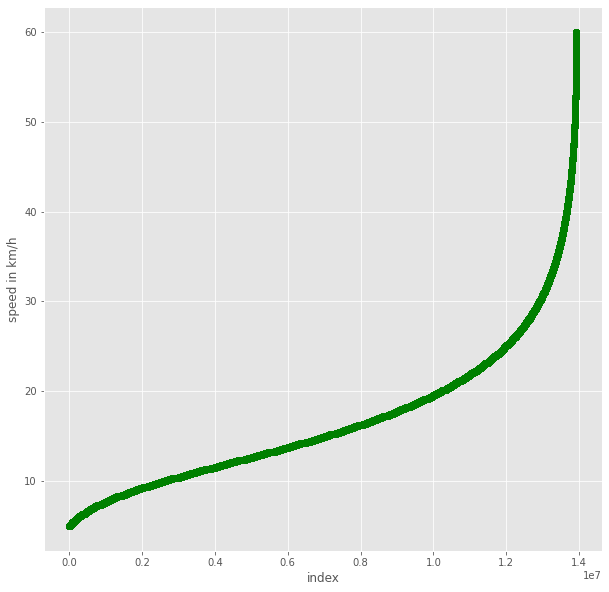

In [ ]:
# speed
valid_records = valid_records.loc[(valid_records.speed >= speed_t[0]) & 
                                          (valid_records.speed <= speed_t[1])]
plt.figure(figsize=(10,10))
plt.scatter(range(len(valid_records["speed"])), np.sort(valid_records["speed"].values), color = 'green')
plt.xlabel('index')
plt.ylabel('speed in km/h')
plt.show()

Remove trips with unreal haversine distance

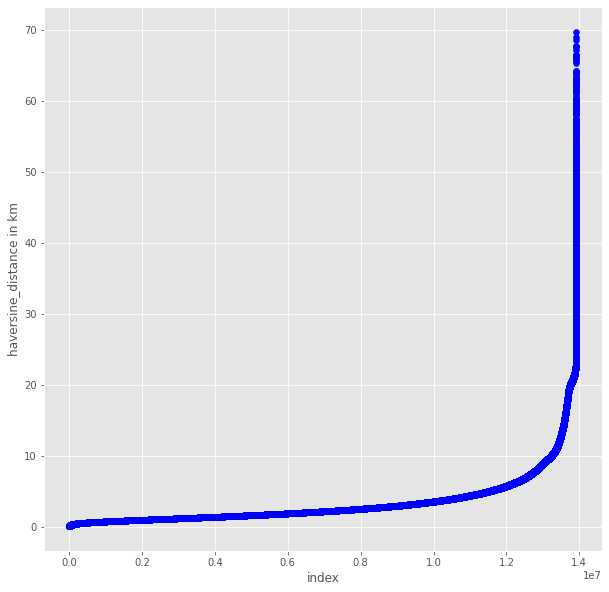

In [ ]:
# haversine_distance
valid_records = valid_records.loc[(valid_records.haversine_distance >= haversine_distance_t[0]) & 
                                          (valid_records.haversine_distance <= haversine_distance_t[1])]
plt.figure(figsize=(10,10))
plt.scatter(range(len(valid_records["haversine_distance"])), np.sort(valid_records["haversine_distance"]), color = 'blue')
plt.xlabel('index')
plt.ylabel('haversine_distance in km')
plt.show()

Remove trips with unreal trip time

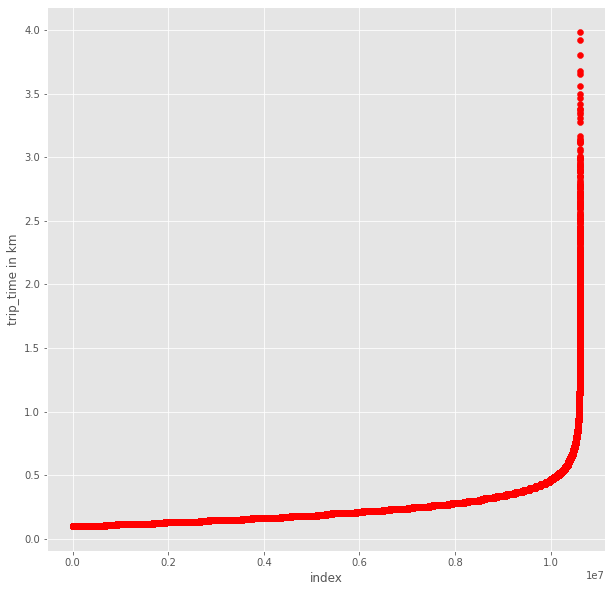

In [ ]:
# trip_time
valid_records = valid_records.loc[(valid_records.trip_time >= trip_time_t[0]) & 
                                          (valid_records.trip_time <= trip_time_t[1])]
plt.figure(figsize=(10,10))
plt.scatter(range(len(valid_records["trip_time"])), np.sort(valid_records["trip_time"]), color = 'red')
plt.xlabel('index')
plt.ylabel('trip_time in km')
plt.show()

Final amount of valid records

In [ ]:
valid_records.shape

## Add intermediate trips

In [ ]:
# Treesholds
haversine_distance_t = (0.1, 70)
trip_time_t = (0.1, 4.0)
speed_t = (5, 60)

# define more restrictive thresholds for the intermediate trips
intermediate_distance_t = (0.5, 20)
intermediate_trip_time_t = (0.1, 1.0)
intermediate_speed_t = (5, 40)

In [ ]:
# Retrieve the valid trips
query = ('SELECT medallion, hack_license, pickup_datetime, dropoff_datetime, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude '+
         'FROM trip_record WHERE '+ where_clause + ' ORDER BY medallion, pickup_datetime') #LIMIT 100000
t1 = datetime.now()
valid_records = pd.read_sql_query( query, nyc_database, params={"min_long":min_long, "max_long":max_long, "min_lat":min_lat, "max_lat":max_lat, "upper":upper, "lower":lower})
t2 = datetime.now()
delta = t2 - t1
print("time for query: {}".format(delta.seconds))

time for query: 194


**To iterate across pairs of rows we need to make a copy of our dataframe and shif it by -1, so the line 1 will be concatenate with the line 2 and so on.**

In [ ]:
# Convert the datetimes from strings to datetimes
valid_records["pickup_datetime"] = pd.to_datetime(valid_records["pickup_datetime"])
valid_records["dropoff_datetime"] = pd.to_datetime(valid_records["dropoff_datetime"])

In [ ]:
# sort the records
valid_records.sort_values(by=['medallion', 'pickup_datetime'], inplace=True)

In [ ]:
# Rename the columns for the dataframe copy
print("Renaming the new columns...")
new_columns_name = np.apply_along_axis(lambda column: column+'_b', 0, np.array(valid_records.columns))

# Copy the dataframe and use the new columns names (takes some time..)
print("Copying the dataframe...")
#valid_records_copy = pd.DataFrame(data=valid_records.values, columns=new_columns_name)
valid_records_copy  = valid_records.copy()
valid_records_copy.columns = new_columns_name

# Shift the copy dataframe
print("Shifting the copied dataframe...")
valid_records_copy = valid_records_copy.shift(-1)

# concatenate the dataframes 
print("Concatenating the two dataframes...")
concatenated_dataframes = pd.concat([valid_records, valid_records_copy], axis=1, sort=False).dropna()

Renaming the new columns...
Copying the dataframe...
Shifting the copied dataframe...
Concatenating the two dataframes...


In [ ]:
concatenated_dataframes.dtypes

medallion                       object
hack_license                    object
pickup_datetime         datetime64[ns]
dropoff_datetime        datetime64[ns]
pickup_longitude               float64
pickup_latitude                float64
dropoff_longitude              float64
dropoff_latitude               float64
trip_time                      float64
haversine_distance             float64
speed                          float64
medallion_b                     object
hack_license_b                  object
pickup_datetime_b       datetime64[ns]
dropoff_datetime_b      datetime64[ns]
pickup_longitude_b             float64
pickup_latitude_b              float64
dropoff_longitude_b            float64
dropoff_latitude_b             float64
trip_time_b                    float64
haversine_distance_b           float64
speed_b                        float64
dtype: object

To generate the intermediate trips we need a function to apply on each row.

This function will make some checks and then return the new computed row.

If an intermediate trip is not possibile, the function returns a None row.


In [ ]:
# Min time allowed between two trips and min intermediate trip length
min_time = intermediate_trip_time_t[0]
# Max time allowed between two trips and max intermediate trip length
max_time = intermediate_trip_time_t[1]

# Min distance allowed between two trips and min intermediate trip distance
min_distance = intermediate_distance_t[0]
# Max distance allowed between two trips and max intermediate trip distance
max_distance = intermediate_distance_t[1]

# Min speed allowed between two trips and min intermediate trip speed
min_speed = intermediate_speed_t[0]
# Max speed allowed between two trips and max intermediate trip speed
max_speed = intermediate_speed_t[1]

# we need to reduce the number of rows first
concatenated_dataframes['intermediate_time'] = (concatenated_dataframes['pickup_datetime_b'] - 
                                                concatenated_dataframes['dropoff_datetime']).dt.total_seconds()
concatenated_dataframes['intermediate_time'] = refine_time(concatenated_dataframes['intermediate_time'].values)

concatenated_dataframes['intermediate_distance'] = haversine_np(concatenated_dataframes["pickup_latitude_b"].values, concatenated_dataframes["pickup_longitude_b"].values, 
                     concatenated_dataframes["dropoff_latitude"].values, concatenated_dataframes["dropoff_longitude"].values)
concatenated_dataframes['intermediate_speed'] = round(concatenated_dataframes['intermediate_distance']/concatenated_dataframes['intermediate_time'], 1)

candidates = concatenated_dataframes.loc[((concatenated_dataframes['medallion'] == concatenated_dataframes['medallion_b']) & (concatenated_dataframes['hack_license'] == concatenated_dataframes['hack_license_b'])) &
                                         ((concatenated_dataframes['intermediate_time'] <= max_time) & (concatenated_dataframes['intermediate_time'] >= min_time)) & 
                                         ((concatenated_dataframes['intermediate_distance'] <= max_distance) & (concatenated_dataframes['intermediate_distance'] >= min_distance)) &
                                         ((concatenated_dataframes['intermediate_speed'] <= max_speed) & (concatenated_dataframes['intermediate_speed'] >= min_speed))]
candidates.shape
                              

(3672324, 25)

In [ ]:
# Change the columns names
intermediate_trips = candidates[['medallion', 'hack_license', 'dropoff_datetime', 'pickup_datetime_b', 'dropoff_longitude', 'dropoff_latitude',
                                 'pickup_longitude_b','pickup_latitude_b', 'intermediate_distance', 'intermediate_time','intermediate_speed']]

intermediate_trips = intermediate_trips.rename(columns={'medallion':'medallion', 'hack_license':'hack_license', 'dropoff_datetime':'pickup_datetime', 'pickup_datetime_b':'dropoff_datetime', 
                                   'pickup_longitude_b':'dropoff_longitude',
                                   'pickup_latitude_b':'dropoff_latitude', 
                                    'dropoff_longitude':'pickup_longitude',
                                   'dropoff_latitude':'pickup_latitude', 
                                   'intermediate_distance': 'haversine_distance',
                                   'intermediate_time':'trip_time', 'intermediate_speed':'speed'})

In [ ]:
intermediate_trips

,medallion,hack_license,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,haversine_distance,trip_time,speed
1473399,00005007A9F30E289E760362F69E4EAD,A9AE329EA1138052DAC8FDFD8BA86603,2013-01-01 02:16:48,2013-01-01 02:31:09,-73.973053,40.792763,-73.984711,40.769283,2.789,0.239,11.7
12957388,00005007A9F30E289E760362F69E4EAD,A9AE329EA1138052DAC8FDFD8BA86603,2013-01-01 03:00:27,2013-01-01 03:06:36,-73.993317,40.758999,-74.001915,40.760899,0.754,0.102,7.4
1549352,00005007A9F30E289E760362F69E4EAD,A9AE329EA1138052DAC8FDFD8BA86603,2013-01-01 03:17:46,2013-01-01 03:27:23,-73.972771,40.756611,-73.983292,40.761707,1.052,0.160,6.6
2664094,00005007A9F30E289E760362F69E4EAD,A9AE329EA1138052DAC8FDFD8BA86603,2013-01-01 04:38:37,2013-01-01 04:46:57,-73.970795,40.764439,-73.988159,40.764755,1.463,0.139,10.5
6361073,00005007A9F30E289E760362F69E4EAD,43468C5D35F828693D96CB7CC9FDF341,2013-01-01 09:33:15,2013-01-01 09:46:11,-73.959076,40.716599,-73.980301,40.722206,1.894,0.216,8.8
...,...,...,...,...,...,...,...,...,...,...,...
14066021,FFFECF75AB6CC4FF9E8A8B633AB81C26,648659963B4639CA17884B391333A9C3,2013-01-31 14:44:00,2013-01-31 14:50:00,-73.994293,40.722755,-74.000450,40.732441,1.195,0.100,12.0
10560197,FFFECF75AB6CC4FF9E8A8B633AB81C26,D81D2A6BD1DFF04666B7F6E1DDDD5ADF,2013-01-31 18:22:00,2013-01-31 18:37:00,-73.985054,40.744747,-73.972382,40.758396,1.855,0.250,7.4
10907611,FFFECF75AB6CC4FF9E8A8B633AB81C26,D81D2A6BD1DFF04666B7F6E1DDDD5ADF,2013-01-31 19:07:00,2013-01-31 19:27:00,-73.967987,40.787090,-73.981651,40.768051,2.409,0.333,7.2
1718072,FFFECF75AB6CC4FF9E8A8B633AB81C26,D81D2A6BD1DFF04666B7F6E1DDDD5ADF,2013-01-31 20:22:00,2013-01-31 20:28:00,-73.982880,40.739799,-73.990135,40.730373,1.213,0.100,12.1


In [ ]:
# compute extra features now, before now it would have just added complexity to the big operations we made to compute the intermediate trips
valid_records['trip_time'] = (valid_records['dropoff_datetime'] - valid_records['pickup_datetime']).dt.total_seconds()
valid_records['trip_time'] = refine_time(valid_records['trip_time'].values)
valid_records['haversine_distance'] = haversine_np(valid_records["pickup_latitude"], valid_records["pickup_longitude"], 
                     valid_records["dropoff_latitude"], valid_records["dropoff_longitude"])
valid_records['speed'] = round(valid_records['haversine_distance']/valid_records['trip_time'], 1)

# Union of the original valid trips and the new intermediate trips
all_valid_records = pd.concat([valid_records, intermediate_trips], axis=0)

# Sort the records by medallion and pickup_time
all_valid_records = all_valid_records.sort_values(by=['medallion', 'pickup_datetime'])

In [ ]:
all_valid_records.head(20)

,medallion,hack_license,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_time,haversine_distance,speed
0,00005007A9F30E289E760362F69E4EAD,A9AE329EA1138052DAC8FDFD8BA86603,2013-01-01 00:29:39,2013-01-01 00:37:47,-73.976624,40.751686,-73.949348,40.776871,0.136,3.622,26.6
1,00005007A9F30E289E760362F69E4EAD,A9AE329EA1138052DAC8FDFD8BA86603,2013-01-01 00:39:16,2013-01-01 00:58:43,-73.948524,40.778000,-73.978966,40.780052,0.324,2.573,7.9
2,00005007A9F30E289E760362F69E4EAD,A9AE329EA1138052DAC8FDFD8BA86603,2013-01-01 00:59:38,2013-01-01 01:05:59,-73.979164,40.780136,-73.961884,40.774754,0.106,1.573,14.8
3,00005007A9F30E289E760362F69E4EAD,A9AE329EA1138052DAC8FDFD8BA86603,2013-01-01 01:07:33,2013-01-01 01:19:52,-73.962669,40.775368,-73.956116,40.804432,0.205,3.279,16.0
4,00005007A9F30E289E760362F69E4EAD,A9AE329EA1138052DAC8FDFD8BA86603,2013-01-01 01:21:23,2013-01-01 01:56:09,-73.955887,40.804317,-74.000214,40.721714,0.579,9.915,17.1
5,00005007A9F30E289E760362F69E4EAD,A9AE329EA1138052DAC8FDFD8BA86603,2013-01-01 01:57:45,2013-01-01 02:16:48,-74.002373,40.719803,-73.973053,40.792763,0.318,8.480,26.7
5,00005007A9F30E289E760362F69E4EAD,A9AE329EA1138052DAC8FDFD8BA86603,2013-01-01 02:16:48,2013-01-01 02:31:09,-73.973053,40.792763,-73.984711,40.769283,0.239,2.789,11.7
6,00005007A9F30E289E760362F69E4EAD,A9AE329EA1138052DAC8FDFD8BA86603,2013-01-01 02:31:09,2013-01-01 02:42:14,-73.984711,40.769283,-73.953056,40.780083,0.185,2.924,15.8
7,00005007A9F30E289E760362F69E4EAD,A9AE329EA1138052DAC8FDFD8BA86603,2013-01-01 02:43:02,2013-01-01 03:00:27,-73.953056,40.780090,-73.993317,40.758999,0.290,4.123,14.2
7,00005007A9F30E289E760362F69E4EAD,A9AE329EA1138052DAC8FDFD8BA86603,2013-01-01 03:00:27,2013-01-01 03:06:36,-73.993317,40.758999,-74.001915,40.760899,0.102,0.754,7.4


In [ ]:
all_valid_records.shape

(14283929, 11)

## Statistics on full dataset
*From this analysis we can see that there are few outlier considering the values of distance, time and speed*

*We should remove them*

### First and Last date


In [ ]:
# pickup
max_pickup_date = all_valid_records["pickup_datetime"].max()
min_pickup_date= all_valid_records["pickup_datetime"].min()


# dropoff
max_dropoff_date = all_valid_records["dropoff_datetime"].max()
min_dropoff_date= all_valid_records["dropoff_datetime"].min()



print("Pickup: ")
print("Min Date: ", min_pickup_date)
print("Max Date: ", max_pickup_date)


print(" ")

print("Dropoff: ")
print("Min Date: ", min_dropoff_date)
print("Max Date: ", max_dropoff_date)

Pickup: 
Min Date:  2013-01-01 00:00:00
Max Date:  2013-01-31 23:59:59
 
Dropoff: 
Min Date:  2013-01-01 00:06:00
Max Date:  2013-02-01 01:37:27


### Min and Max **Longitude** and **Latitude** for Pickup and Dropoff


In [ ]:

# pickup
max_pickup_longitude = all_valid_records["pickup_longitude"].max()
min_pickup_longitude= all_valid_records["pickup_longitude"].min()
max_pickup_latitude = all_valid_records["pickup_latitude"].max()
min_pickup_latitude= all_valid_records["pickup_latitude"].min()

# dropoff
max_dropoff_latitude = all_valid_records["dropoff_latitude"].max()
min_dropoff_latitude= all_valid_records["dropoff_latitude"].min()
max_dropoff_longitude = all_valid_records["dropoff_longitude"].max()
min_dropoff_longitude= all_valid_records["dropoff_longitude"].min()


print("Pickup: ")
print("Min Latitude: ", min_pickup_latitude)
print("Min Longitude: ", min_pickup_longitude)
print("Max Latitude: ", max_pickup_latitude)
print("Max Longitude: ", max_pickup_longitude)

print(" ")

print("Dropoff: ")
print("Min Latitude: ", min_dropoff_latitude)
print("Min Longitude: ", min_dropoff_longitude)
print("Max Latitude: ", max_dropoff_latitude)
print("Max Longitude: ", max_dropoff_longitude)

Pickup: 
Min Latitude:  40.095692
Min Longitude:  -75.360687
Max Latitude:  41.908611
Max Longitude:  -72.975975
 
Dropoff: 
Min Latitude:  39.811676
Min Longitude:  -75.40909599999999
Max Latitude:  41.908611
Max Longitude:  -72.917526


### Most common medallion

In [ ]:
all_valid_records['medallion'].value_counts()

6FFCF7A4F34BA44239636028E680E438    2071
849E486825860106403FB991A763BCC3    2054
075E4BFE6607421289B566A32BC135E5    2032
A979CDA04CFB8BA3D3ACBA7E8D7F0661    2022
0832BDD7A3BE2ECA14DC518FCA8B7E5D    2014
                                    ... 
B8C5E185F13961324396AB8F13C1BF19       1
97D167499FF0A1F60E55656B291801D7       1
59E6C24624083FD6079C04014EB5317D       1
8579F879F5FABB11866B359A37C80F73       1
816590D6C11CDAB47B76C7C6750B6094       1
Name: medallion, Length: 13250, dtype: int64

### Most common Medallion - Hack_license combination

In [ ]:
all_valid_records.groupby(['medallion','hack_license']).size().sort_values(ascending=False)
#counts.index[0] 

medallion                         hack_license                    
C6C2AA4F89E3C1ED8B58FFC7AE6D931C  F49FD0D84449AE7F72F3BC492CD6C754    1729
E2D92DC49D2E3A841FFCE27ADA3921F0  51C1BE97280A80EBFA8DAD34E1956CF6    1610
4D254D147893657D7110E9DBE9483B24  22CA618759C716436EA3257480199A32    1608
C3E7F827F0CF5A5B9162DC0A6D2E726C  CE625FD96D0FAFC812A6957139B354A1    1587
24F08861B2158ACD82BE9AD23EE3B06E  3D757E111C78F5CAC83D44A92885D490    1572
                                                                      ... 
39A60F14324688F6BB35EE079D492156  7356659DFDD022D4678C1892721B905F       1
E3B9F52165B0F6205F0B69CB54D4AAC2  82BD06547AC4DD8F507414B3CFDE4DD7       1
E382AC96D9E9E3A86DFC268AD5D2C4A2  1B4F157B2670FA442D4BF2239F232F86       1
BD05DDE1C3EA5728338E6B8BE5E52A42  CFCD208495D565EF66E7DFF9F98764DA       1
210A732C6222DCCC081C22A5948E3B8D  EA7A425B3BF3EAB2F13C333FBD34AB04       1
Length: 99302, dtype: int64

### Compute mean, min and max ***trip distance***


In [ ]:
mean_d = all_valid_records["haversine_distance"].mean()
max_d = all_valid_records["haversine_distance"].max()
min_d = all_valid_records["haversine_distance"].min()

print("The mean distance is: ", mean_d)
print("The max distance is: ", max_d)
print("The min distance is: ", min_d)
print("The distances are represented in Km unit")

The mean distance is:  3.71616833403844
The max distance is:  69.69
The min distance is:  0.496
The distances are represented in Km unit


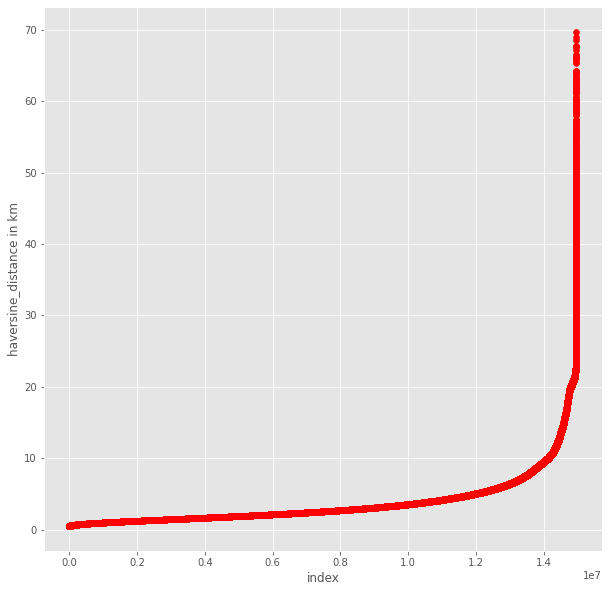

In [ ]:
# plot values to spot outliers
plt.figure(figsize=(10,10))
plt.scatter(range(len(all_valid_records["haversine_distance"])), np.sort(all_valid_records["haversine_distance"]), color = 'red')
plt.xlabel('index')
plt.ylabel('haversine_distance in km')
plt.show()

### Compute mean, min and max ***trip time***


In [ ]:
mean_t = all_valid_records["trip_time"].mean()
max_t = all_valid_records["trip_time"].max()
min_t = all_valid_records["trip_time"].min()

print("The mean trip_time is: ", mean_t)
print("The max trip_time is: ", max_t)
print("The min trip_time is: ", min_t)
print("The trip_times are represented in hours")

The mean trip_time is:  0.2362602384114245
The max trip_time is:  3.985
The min trip_time is:  0.1
The trip_times are represented in hours


In [ ]:
# Row with the max time
index = all_valid_records["trip_time"].argmax()
all_valid_records.iloc[index]

medallion             8B92CB499DFC80FC3422BC4A05BFA582
hack_license          D605BB43ABD8208CB08D0E36BDFD393E
pickup_datetime                    2013-01-12 18:56:25
dropoff_datetime                   2013-01-12 22:55:32
pickup_longitude                                -73.79
pickup_latitude                                40.6439
dropoff_longitude                             -73.9674
dropoff_latitude                               40.7951
trip_time                                        3.985
haversine_distance                              22.488
speed                                              5.6
Name: 7795635, dtype: object

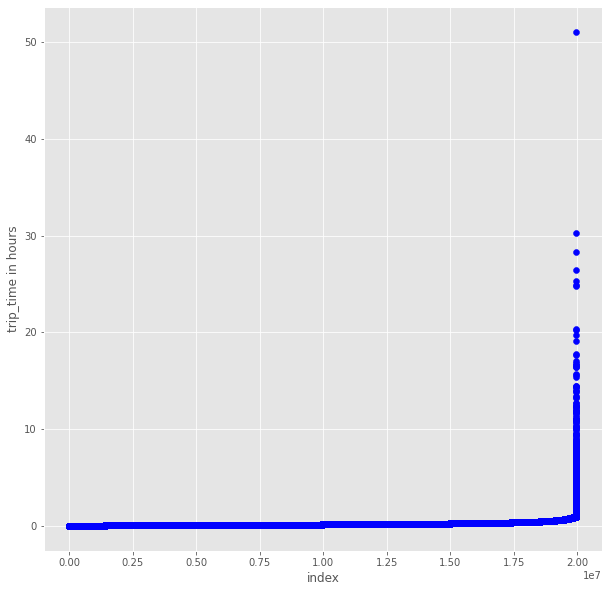

In [ ]:
# plot values to spot outliers
plt.figure(figsize=(10,10))
plt.scatter(range(len(all_valid_records["trip_time"])), np.sort(all_valid_records["trip_time"]),color = 'blue')
plt.xlabel('index')
plt.ylabel('trip_time in hours')
plt.show()

### Compute mean, min and max ***speed***

In [ ]:
mean_speed = all_valid_records["speed"].mean()
max_speed = all_valid_records["speed"].max()
min_speed = all_valid_records["speed"].min()

print("The mean speed is: ", mean_speed)
print("The max speed is: ", max_speed)
print("The min speed is: ", min_speed)

The mean speed is:  15.049081683867563
The max speed is:  60.0
The min speed is:  5.0


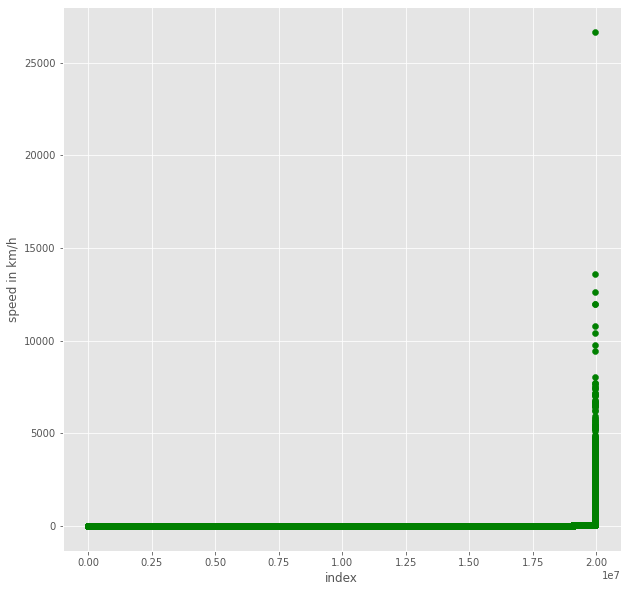

In [ ]:
# plot values to spot outliers
plt.figure(figsize=(10,10))
plt.scatter(range(len(all_valid_records["speed"])), np.sort(all_valid_records["speed"]), color = 'green')
plt.xlabel('index')
plt.ylabel('speed in km/h')
plt.show()

### Worth notice

From this analysis we can see that there are few outlier considering the values of distance, time and speed

We should remove them

## Remove outliers

Remove trips with unreal speed

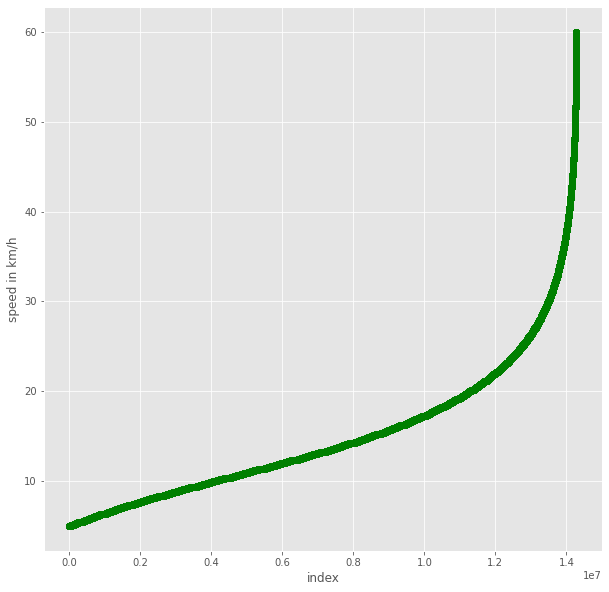

In [ ]:
# speed
all_valid_records = all_valid_records.loc[(all_valid_records.speed >= speed_t[0]) & 
                                          (all_valid_records.speed <= speed_t[1])]
plt.figure(figsize=(10,10))
plt.scatter(range(len(all_valid_records["speed"])), np.sort(all_valid_records["speed"].values), color = 'green')
plt.xlabel('index')
plt.ylabel('speed in km/h')
plt.show()

Remove trips with unreal haversine distance

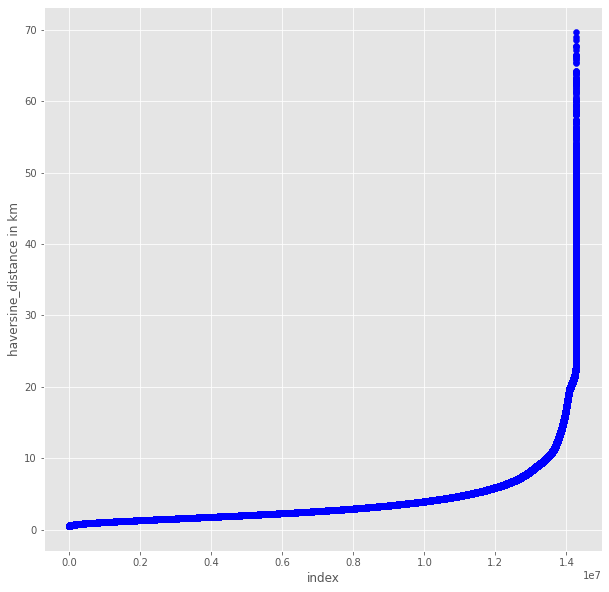

In [ ]:
# haversine_distance
all_valid_records = all_valid_records.loc[(all_valid_records.haversine_distance >= haversine_distance_t[0]) & 
                                          (all_valid_records.haversine_distance <= haversine_distance_t[1])]
plt.figure(figsize=(10,10))
plt.scatter(range(len(all_valid_records["haversine_distance"])), np.sort(all_valid_records["haversine_distance"]), color = 'blue')
plt.xlabel('index')
plt.ylabel('haversine_distance in km')
plt.show()

Remove trips with unreal trip time

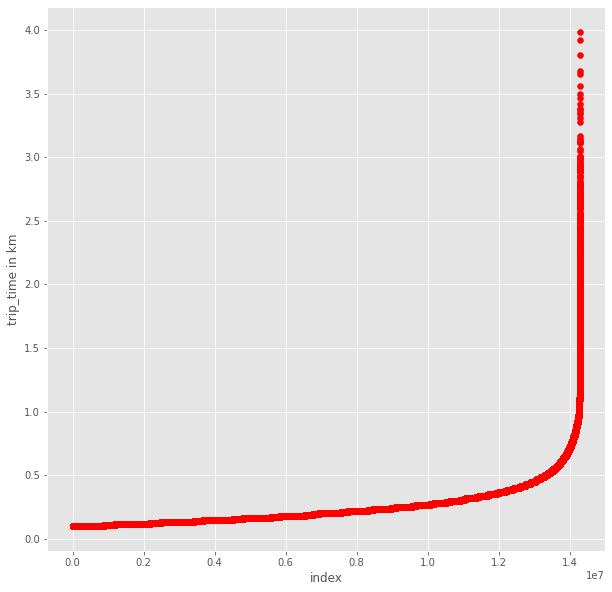

In [ ]:
# trip_time
all_valid_records = all_valid_records.loc[(all_valid_records.trip_time >= trip_time_t[0]) & 
                                          (all_valid_records.trip_time <= trip_time_t[1])]
plt.figure(figsize=(10,10))
plt.scatter(range(len(all_valid_records["trip_time"])), np.sort(all_valid_records["trip_time"]), color = 'red')
plt.xlabel('index')
plt.ylabel('trip_time in km')
plt.show()

In [ ]:
all_valid_records.shape

(14283929, 11)

## Datetimes

We have datetimes which are useful for the analysis, but for our NN we need to refactor these attributes:

*  week_day
*  hour
*  month

In [ ]:
# already did it
all_valid_records["pickup_datetime"] = pd.to_datetime(all_valid_records["pickup_datetime"])
all_valid_records["dropoff_datetime"] = pd.to_datetime(all_valid_records["dropoff_datetime"])

In [ ]:
all_valid_records["pickup_week_day"] = all_valid_records.pickup_datetime.dt.dayofweek
all_valid_records["pickup_hour"] = all_valid_records.pickup_datetime.dt.hour
all_valid_records["pickup_month"] = all_valid_records.pickup_datetime.dt.month
all_valid_records["pickup_day"] = all_valid_records.pickup_datetime.dt.day

all_valid_records["dropoff_week_day"] = all_valid_records.dropoff_datetime.dt.dayofweek
all_valid_records["dropoff_hour"] = all_valid_records.dropoff_datetime.dt.hour
all_valid_records["dropoff_month"] = all_valid_records.dropoff_datetime.dt.month
all_valid_records["dropoff_day"] = all_valid_records.dropoff_datetime.dt.day

In [ ]:
all_valid_records.head()

,medallion,hack_license,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_time,haversine_distance,speed,pickup_week_day,pickup_hour,pickup_month,pickup_day,dropoff_week_day,dropoff_hour,dropoff_month,dropoff_day
8896484,00005007A9F30E289E760362F69E4EAD,A9AE329EA1138052DAC8FDFD8BA86603,2013-01-01 00:29:39,2013-01-01 00:37:47,-73.976624,40.751686,-73.949348,40.776871,0.136,3.622,26.6,1,0,1,1,1,0,1,1
13356912,00005007A9F30E289E760362F69E4EAD,A9AE329EA1138052DAC8FDFD8BA86603,2013-01-01 00:39:16,2013-01-01 00:58:43,-73.948524,40.778000,-73.978966,40.780052,0.324,2.573,7.9,1,0,1,1,1,0,1,1
8110791,00005007A9F30E289E760362F69E4EAD,A9AE329EA1138052DAC8FDFD8BA86603,2013-01-01 00:59:38,2013-01-01 01:05:59,-73.979164,40.780136,-73.961884,40.774754,0.106,1.573,14.8,1,0,1,1,1,1,1,1
11554091,00005007A9F30E289E760362F69E4EAD,A9AE329EA1138052DAC8FDFD8BA86603,2013-01-01 01:07:33,2013-01-01 01:19:52,-73.962669,40.775368,-73.956116,40.804432,0.205,3.279,16.0,1,1,1,1,1,1,1,1
12509246,00005007A9F30E289E760362F69E4EAD,A9AE329EA1138052DAC8FDFD8BA86603,2013-01-01 01:21:23,2013-01-01 01:56:09,-73.955887,40.804317,-74.000214,40.721714,0.579,9.915,17.1,1,1,1,1,1,1,1,1


In [ ]:
import gc 

del valid_records
del valid_records_copy
del intermediate_trips
del concatenated_dataframes
del candidates

gc.collect()

146

In [ ]:
all_valid_records.to_csv(baseURL + 'january_before_zones.csv', index = False)

In [ ]:
all_valid_records = pd.read_csv(baseURL + 'january_before_zones.csv')

### Compute time differences

In [ ]:
records = all_valid_records[['medallion', 'pickup_datetime', 'dropoff_datetime']].copy()

In [ ]:
records.pickup_datetime = pd.to_datetime(records.pickup_datetime)
records.dropoff_datetime = pd.to_datetime(records.dropoff_datetime)

In [ ]:
count = records.medallion.value_counts()
count

6FFCF7A4F34BA44239636028E680E438    1984
849E486825860106403FB991A763BCC3    1981
075E4BFE6607421289B566A32BC135E5    1949
A979CDA04CFB8BA3D3ACBA7E8D7F0661    1946
0832BDD7A3BE2ECA14DC518FCA8B7E5D    1911
                                    ... 
8579F879F5FABB11866B359A37C80F73       1
59E6C24624083FD6079C04014EB5317D       1
B8C5E185F13961324396AB8F13C1BF19       1
EC772A8C882686041534A0E94EA0EA8E       1
816590D6C11CDAB47B76C7C6750B6094       1
Name: medallion, Length: 13250, dtype: int64

In [ ]:
medallions = count.loc[count>1000].index

In [ ]:
records = records.loc[records.medallion.isin(medallions)]

Datetimes to timestamps

In [ ]:
records['pickup_ts'] = records.pickup_datetime.values.astype(np.int64) // 10 ** 9

In [ ]:
records['dropoff_ts'] = records.dropoff_datetime.values.astype(np.int64) // 10 ** 9

In [ ]:
import datetime 
# Count the records for each user
# count = records.medallion.value_counts()

# Select the users with a number of records greater than the median
# records = records[records['medallion'].isin(count.index[count > 30])]

# List to collect differences
time_diff = []

sf.sort_values(by=['medallion', 'pickup_ts'], inplace=True)

# For each user
for n, medallion in enumerate(medallions):

  sf = records.loc[records.medallion == medallion].copy()
  
  # Get the timestamps of the observations
  pickup_time = sf.pickup_ts.values

  # Get the timestamps of the observations
  dropoff_time = sf.dropoff_ts.values

  # Create a temporary array
  copy = np.zeros(pickup_time.shape[0], dtype=np.int32)

  # Copy the end timestamps shifted right by 1
  copy[1:] = pickup_time[:pickup_time.shape[0]-1]

  # compute the time difference
  diff = dropoff_time - copy
  diff[0] = 0

  # Cast from seconds to hours
  diff = diff /3600

  time_diff.extend(list(diff))


In [ ]:
# Save the numpy
np.save(baseURL + 'NYC_time_diff.npy', np.array(time_diff))

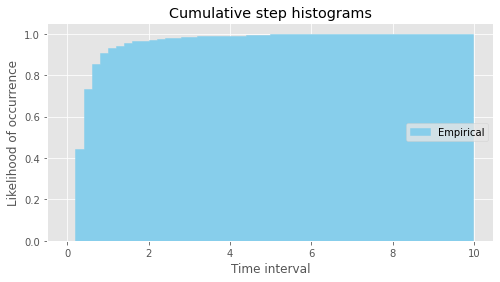

In [ ]:
import matplotlib.pyplot as plt

n_bins = 50
fig, ax = plt.subplots(figsize=(8, 4))

# plot the cumulative histogram
n, bins, patches = ax.hist(time_diff[:1000], n_bins, density=True, histtype='stepfilled',
                           cumulative=True, label='Empirical',  color = "skyblue", ec="skyblue")


# tidy up the figure
ax.legend(loc='right')
ax.set_title('Cumulative step histograms')
ax.set_xlabel('Time interval')
ax.set_ylabel('Likelihood of occurrence')

plt.show()

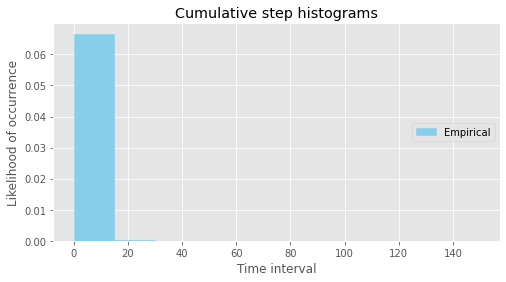

In [ ]:
# we can't plot time differences of 4000h... we need to remove them just for have a clean plot

time_diff_c = np.array(time_diff)[np.array(time_diff) < 150]
n_bins = 10
fig, ax = plt.subplots(figsize=(8, 4))
# plot the cumulative histogram
n, bins, patches = ax.hist(time_diff_c, n_bins, density=True, histtype='stepfilled',
                           cumulative=False, label='Empirical',  color = "skyblue", ec="skyblue")


# tidy up the figure
ax.legend(loc='right')
ax.set_title('Cumulative step histograms')
ax.set_xlabel('Time interval')
ax.set_ylabel('Likelihood of occurrence')

plt.show()

In [ ]:
print("Number of places with a time difference over 80 hours: ", np.sum(np.array(time_diff) > 80))
print("Number of places with a time difference less than 80 hours: ", np.sum(np.array(time_diff) <= 80))
print("Number of places with a time difference less than 20 hours: ", np.sum(np.array(time_diff) <= 20))
print("Number of places with a time difference less than 2 hours: ", np.sum(np.array(time_diff) <= 2))

Number of places with a time difference over 80 hours:  130
Number of places with a time difference less than 80 hours:  11129761
Number of places with a time difference less than 20 hours:  11123601
Number of places with a time difference less than 2 hours:  10556234


In [ ]:
diff_t = np.array(time_diff)
print("Mean time difference: ", np.mean(diff_t))
print("Max time difference:", np.max(diff_t))
print("Min time difference: ", np.min(diff_t))

Mean time difference:  0.8152307210625682
Max time difference: 254.88333333333333
Min time difference:  0.0


## Join location ID

To reduce at the minimum size the dimension of the dataset to upload on Google BigQuery, we can limited the columns to:


* **pickup_longitude**
* **pickup_latitude**
* **dropoff_longitude**
* **dropoff_latitude**

Then joining with the zones we can simply add the ZoneID, 
We will be able to match it with our local dataset.

The valid rows which are in the valid area but now within the NYC boudaries will be mapped to a Zone which represent the outside of the city

The other ones that are in the NYC boudary will be used in bigquery

from BigQuery we will get back these attributes:

[ pickup_longitude, pickup_latitude, dropoff_longitude dropoff_latitude, zone_id, zone_name, borough ] 


in all_valid_records we have some problem of duplicated index (cause from the intermediate trips?)

we need to reindex

In [ ]:
all_valid_records.reset_index(drop=True, inplace=True)

Take the columns we are interested for

In [ ]:
locations = all_valid_records[["pickup_longitude", "pickup_latitude","dropoff_longitude", "dropoff_latitude"]].copy()
locations.head(100)

Save the location data

In [ ]:
# save the csv
locations.to_csv('/Users/AAAA/Desktop/locations.csv', index=False)

Remove coordinates which are outside of NYC

**We don't need this, coordinates not in the zones are simply discarded in the spatial join**

In [ ]:
locations_nyc = locations

Read the taxi zone dataset shapefile

In [ ]:
import geopandas as gpd
from geopandas import GeoSeries
from shapely.geometry import Point, LineString, Polygon, asMultiPoint
import fiona.crs

fp = "/Users/AAAA/Desktop/Dataset/NYC_2013/zones/geo_export_0a808b07-f8b1-420c-8abc-2a96a74a7de7.shp"

# Read the data
zones = gpd.read_file(fp)
zones.head()

,borough,location_i,objectid,shape_area,shape_leng,zone,geometry
0,EWR,1.0,1.0,0.000782,0.116357,Newark Airport,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
1,Queens,2.0,2.0,0.004866,0.433470,Jamaica Bay,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ..."
2,Bronx,3.0,3.0,0.000314,0.084341,Allerton/Pelham Gardens,"POLYGON ((-73.84793 40.87134, -73.84725 40.870..."
3,Manhattan,4.0,4.0,0.000112,0.043567,Alphabet City,"POLYGON ((-73.97177 40.72582, -73.97179 40.725..."
4,Staten Island,5.0,5.0,0.000498,0.092146,Arden Heights,"POLYGON ((-74.17422 40.56257, -74.17349 40.562..."


Check the dataset crs type

In [ ]:
zones.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Drop eventual null rows

In [ ]:
zones = zones[np.invert(zones.isna())]
zones

Check for index duplicates

In [ ]:
locations_nyc[locations_nyc.index.duplicated()]

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude


### Pickup coordinates

Stack latitude and longitude of each row into a numpy array of N x 2 elements

Then generate a list of N Points from that pair of coordinates

In [ ]:
# stack latitude and longitude together 
pickup = np.vstack((locations_nyc["pickup_longitude"].values, locations_nyc["pickup_latitude"].values)).T 

# Convert each couple into a point object
t1 = datetime.now()
points = [Point(i) for i in pickup]
t2 = datetime.now()
delta = t2 - t1
print("time for conversion: {}".format(delta.seconds))

time for conversion: 149


* Create a GeoSeries from the list of Points
* Change the crs to match with the one of zones
* Create a GeoDataframe from the GeoSeries
* Drop any invalid rows

In [ ]:
gs = GeoSeries(points)
gs.crs = fiona.crs.from_epsg(4326)
gd = gpd.GeoDataFrame(geometry=gs)
gd =  gd.loc[gd.is_valid]

/opt/miniconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [ ]:
# Akternative method to change the crs
#gs.crs = {'init': 'epsg:4326', 'no_defs': True}
#gd = gpd.GeoDataFrame(geometry=gs)

In [ ]:
gd.head()

,geometry
0,POINT (-73.97662 40.75169)
1,POINT (-73.94852 40.77800)
2,POINT (-73.97916 40.78014)
3,POINT (-73.96267 40.77537)
4,POINT (-73.95589 40.80432)


Add the original coordinates to the GeoDataframe, so we will have them in the result and we can use them to join back to the dataset

In [ ]:
gd['pickup_longitude'] = locations_nyc["pickup_longitude"].values
gd['pickup_latitude'] = locations_nyc["pickup_latitude"].values

In [ ]:
gd.head()

,geometry,pickup_longitude,pickup_latitude
0,POINT (-73.97662 40.75169),-73.976624,40.751686
1,POINT (-73.94852 40.77800),-73.948524,40.778000
2,POINT (-73.97916 40.78014),-73.979164,40.780136
3,POINT (-73.96267 40.77537),-73.962669,40.775368
4,POINT (-73.95589 40.80432),-73.955887,40.804317


Check the DeoDataframe crs type

In [ ]:
gd.crs

<Geographic 2D CRS: +init=epsg:4326 +no_defs +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Perform a spatial join between out points and the taxi zones

In [ ]:
join = gpd.sjoin(gd, zones, how="inner", op="within")
join.head()

/opt/miniconda3/lib/python3.7/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!(+init=epsg:4326 +no_defs +type=crs != epsg:4326)
  "(%s != %s)" % (left_df.crs, right_df.crs)


,geometry,pickup_longitude,pickup_latitude,index_right,borough,location_i,objectid,shape_area,shape_leng,zone
0,POINT (-73.97662 40.75169),-73.976624,40.751686,161,Manhattan,162.0,162.0,0.000048,0.03527,Midtown East
11,POINT (-73.97277 40.75661),-73.972771,40.756611,161,Manhattan,162.0,162.0,0.000048,0.03527,Midtown East
56,POINT (-73.97391 40.75603),-73.973907,40.756035,161,Manhattan,162.0,162.0,0.000048,0.03527,Midtown East
74,POINT (-73.97316 40.75518),-73.973160,40.755180,161,Manhattan,162.0,162.0,0.000048,0.03527,Midtown East
90,POINT (-73.96718 40.76106),-73.967178,40.761063,161,Manhattan,162.0,162.0,0.000048,0.03527,Midtown East


Create a pandas dataframe with the non spatial data to join back with the original dataset

In [ ]:
# pickup_longitude | pickup_latitude | borough | location_i | zone
pickup_non_spacial_data = pd.DataFrame({'pickup_longitude': join['pickup_longitude'], 'pickup_latitude':join['pickup_latitude'] ,
                                 'pickup_borough': join['borough'], 'pickup_location_id': join['location_i'], 'pickup_zone': join['zone']})

In [ ]:
pickup_non_spacial_data.head()

,pickup_longitude,pickup_latitude,pickup_borough,pickup_location_id,pickup_zone
0,-73.976624,40.751686,Manhattan,162.0,Midtown East
11,-73.972771,40.756611,Manhattan,162.0,Midtown East
56,-73.973907,40.756035,Manhattan,162.0,Midtown East
74,-73.973160,40.755180,Manhattan,162.0,Midtown East
90,-73.967178,40.761063,Manhattan,162.0,Midtown East


### Dropoff

Same thing with the dropoff coordinates

In [ ]:
# stack latitude and longitude together 
dropoff = np.vstack((locations_nyc["dropoff_longitude"].values, locations_nyc["dropoff_latitude"].values)).T 

# Convert each couple into a point object
t1 = datetime.now()
points = [Point(i) for i in dropoff]
t2 = datetime.now()
delta = t2 - t1
print("time for conversion: {}".format(delta.seconds))

time for conversion: 144


In [ ]:
gs = GeoSeries(points)
gs.crs = fiona.crs.from_epsg(4326)
gd = gpd.GeoDataFrame(geometry=gs)
gd =  gd.loc[gd.is_valid]

/opt/miniconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [ ]:
gd['dropoff_longitude'] = locations_nyc["dropoff_longitude"].values
gd['dropoff_latitude'] = locations_nyc["dropoff_latitude"].values

In [ ]:
join = gpd.sjoin(gd, zones, how="inner", op="within")
join.head()

/opt/miniconda3/lib/python3.7/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!(+init=epsg:4326 +no_defs +type=crs != epsg:4326)
  "(%s != %s)" % (left_df.crs, right_df.crs)


,geometry,dropoff_longitude,dropoff_latitude,index_right,borough,location_i,objectid,shape_area,shape_leng,zone
0,POINT (-73.94935 40.77687),-73.949348,40.776871,262,Manhattan,262.0,262.0,0.000122,0.049064,Yorkville East
320,POINT (-73.94830 40.77297),-73.948303,40.772968,262,Manhattan,262.0,262.0,0.000122,0.049064,Yorkville East
435,POINT (-73.94866 40.77410),-73.948662,40.774105,262,Manhattan,262.0,262.0,0.000122,0.049064,Yorkville East
482,POINT (-73.94766 40.77544),-73.947662,40.775440,262,Manhattan,262.0,262.0,0.000122,0.049064,Yorkville East
747,POINT (-73.94652 40.77238),-73.946518,40.772381,262,Manhattan,262.0,262.0,0.000122,0.049064,Yorkville East


In [ ]:
# dropoff_longitude | dropoff_latitude | borough | location_i | zone
dropoff_non_spacial_data = pd.DataFrame({'dropoff_longitude': join['dropoff_longitude'], 'dropoff_latitude':join['dropoff_latitude'] ,
                                 'dropoff_borough': join['borough'], 'dropoff_location_id': join['location_i'], 'dropoff_zone': join['zone']})

### Check for index dulicates

There are coordinates which match with more than one zone and create duplicates

In [ ]:
all_valid_records[all_valid_records.index.duplicated()]

,medallion,hack_license,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_time,haversine_distance,speed,pickup_week_day,pickup_hour,pickup_month


In [ ]:
pickup_non_spacial_data[pickup_non_spacial_data.index.duplicated()]

,pickup_longitude,pickup_latitude,pickup_borough,pickup_location_id,pickup_zone


In [ ]:
dropoff_non_spacial_data[dropoff_non_spacial_data.index.duplicated()]#.index[0]

,dropoff_longitude,dropoff_latitude,dropoff_borough,dropoff_location_id,dropoff_zone
7984683,-73.974968,40.748501,Manhattan,233.0,UN/Turtle Bay South


If there is a duplicate, locate it by the index

In [ ]:
dropoff_non_spacial_data.loc[7971094]

,dropoff_longitude,dropoff_latitude,dropoff_borough,dropoff_location_id,dropoff_zone
7971094,-73.974968,40.748501,Manhattan,170.0,Murray Hill
7971094,-73.974968,40.748501,Manhattan,233.0,UN/Turtle Bay South


**It is not a problem cause by my implementation, also BigQuery make this duplicate**

We can drop the duplicate and keep just the first result

In [ ]:
# Drop duplicates
dropoff_non_spacial_data = dropoff_non_spacial_data.loc[~dropoff_non_spacial_data.index.duplicated(keep='first')]

Check Most common combination of dropoff_longitude and dropoff_latitude

In [ ]:
# Most common combination of dropoff_longitude and dropoff_latitude
dropoff_non_spacial_data.groupby(['dropoff_longitude','dropoff_latitude']).size().sort_values(ascending=False)


dropoff_longitude  dropoff_latitude
-73.874474         40.774071           26
-73.870918         40.773773           26
                   40.773766           25
-73.874489         40.774078           24
-73.870895         40.773766           24
                                       ..
-73.973351         40.769203            1
                   40.769188            1
                   40.769176            1
                   40.769165            1
-74.252434         40.511765            1
Length: 12197563, dtype: int64

Remove unecessary columns

In [ ]:
pickup_zones = pickup_non_spacial_data[ ['pickup_longitude', 'pickup_latitude', 'pickup_location_id']].copy()

In [ ]:
dropoff_zones = dropoff_non_spacial_data[ ['dropoff_longitude', 'dropoff_latitude', 'dropoff_location_id']].copy()

In [ ]:
# save the csv
pickup_zones.to_csv('/Users/AAAA/Desktop/pickup_zones_1.csv', index=False)
dropoff_zones.to_csv('/Users/AAAA/Desktop/dropoff_zones_1.csv', index=False)

In [ ]:
# read the csv
pickup_zones = pd.read_csv(baseURL + 'pickup_zones_1.csv')
dropoff_zones = pd.read_csv(baseURL + 'dropoff_zones_1.csv')

### Joining separately

In [ ]:
all_valid_records

In [ ]:
trips_with_zones = pd.merge(all_valid_records, pickup_zones,  how='left',
                  left_on=['pickup_longitude','pickup_latitude'],
                  right_on = ['pickup_longitude','pickup_latitude'])

In [ ]:
trips_with_zones.shape

In [ ]:
del trips_with_zones
gc.collect()

This merge returns 26M rows... this because there are duplicates in the pickup_zones table and they match with more than one row each.

we need to drop them

In [ ]:
pickup_zones = pickup_zones.drop_duplicates(subset=['pickup_longitude','pickup_latitude'])

In [ ]:
trips_with_zones = pd.merge(all_valid_records, pickup_zones,  how='left',
                  left_on=['pickup_longitude','pickup_latitude'],
                  right_on = ['pickup_longitude','pickup_latitude'])

In [ ]:
dropoff_zones = dropoff_zones.drop_duplicates(subset=['dropoff_longitude','dropoff_latitude'])

In [ ]:
trips_with_zones = pd.merge(trips_with_zones, dropoff_zones,  how='left',
                  left_on = ['dropoff_longitude','dropoff_latitude'],
                  right_on = ['dropoff_longitude','dropoff_latitude'])

In [ ]:
trips_with_zones

,medallion,hack_license,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_time,haversine_distance,speed,pickup_week_day,pickup_hour,pickup_month,pickup_day,dropoff_week_day,dropoff_hour,dropoff_month,dropoff_day,pickup_location_id,dropoff_location_id
0,00005007A9F30E289E760362F69E4EAD,A9AE329EA1138052DAC8FDFD8BA86603,2013-01-01 00:29:39,2013-01-01 00:37:47,-73.976624,40.751686,-73.949348,40.776871,0.136,3.622,26.6,1,0,1,1,1,0,1,1,162.0,262.0
1,00005007A9F30E289E760362F69E4EAD,A9AE329EA1138052DAC8FDFD8BA86603,2013-01-01 00:39:16,2013-01-01 00:58:43,-73.948524,40.778000,-73.978966,40.780052,0.324,2.573,7.9,1,0,1,1,1,0,1,1,262.0,239.0
2,00005007A9F30E289E760362F69E4EAD,A9AE329EA1138052DAC8FDFD8BA86603,2013-01-01 00:59:38,2013-01-01 01:05:59,-73.979164,40.780136,-73.961884,40.774754,0.106,1.573,14.8,1,0,1,1,1,1,1,1,239.0,236.0
3,00005007A9F30E289E760362F69E4EAD,A9AE329EA1138052DAC8FDFD8BA86603,2013-01-01 01:07:33,2013-01-01 01:19:52,-73.962669,40.775368,-73.956116,40.804432,0.205,3.279,16.0,1,1,1,1,1,1,1,1,236.0,41.0
4,00005007A9F30E289E760362F69E4EAD,A9AE329EA1138052DAC8FDFD8BA86603,2013-01-01 01:21:23,2013-01-01 01:56:09,-73.955887,40.804317,-74.000214,40.721714,0.579,9.915,17.1,1,1,1,1,1,1,1,1,41.0,211.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14283924,FFFECF75AB6CC4FF9E8A8B633AB81C26,D81D2A6BD1DFF04666B7F6E1DDDD5ADF,2013-01-31 21:12:00,2013-01-31 21:25:00,-74.005890,40.740166,-73.992104,40.717636,0.217,2.761,12.7,3,21,1,31,3,21,1,31,158.0,148.0
14283925,FFFECF75AB6CC4FF9E8A8B633AB81C26,D81D2A6BD1DFF04666B7F6E1DDDD5ADF,2013-01-31 22:14:00,2013-01-31 22:20:00,-73.988312,40.743584,-73.994537,40.729446,0.100,1.657,16.6,3,22,1,31,3,22,1,31,234.0,113.0
14283926,FFFECF75AB6CC4FF9E8A8B633AB81C26,D81D2A6BD1DFF04666B7F6E1DDDD5ADF,2013-01-31 22:20:00,2013-01-31 22:26:00,-73.994537,40.729446,-74.001534,40.735813,0.100,0.921,9.2,3,22,1,31,3,22,1,31,NaN,NaN
14283927,FFFECF75AB6CC4FF9E8A8B633AB81C26,D81D2A6BD1DFF04666B7F6E1DDDD5ADF,2013-01-31 22:26:00,2013-01-31 22:52:00,-74.001534,40.735813,-73.941978,40.674843,0.433,8.436,19.5,3,22,1,31,3,22,1,31,249.0,61.0


In [ ]:
trips_with_zones.loc[(trips_with_zones.dropoff_location_id.isnull()) | (trips_with_zones.pickup_location_id.isnull())]

,medallion,hack_license,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_time,haversine_distance,speed,pickup_week_day,pickup_hour,pickup_month,pickup_day,dropoff_week_day,dropoff_hour,dropoff_month,dropoff_day,pickup_location_id,dropoff_location_id
2,00005007A9F30E289E760362F69E4EAD,A9AE329EA1138052DAC8FDFD8BA86603,2013-01-01 00:59:38,2013-01-01 01:05:59,-73.979164,40.780136,-73.961884,40.774754,0.106,1.573,14.8,1,0,1,1,1,1,1,1,239.0,NaN
8,00005007A9F30E289E760362F69E4EAD,A9AE329EA1138052DAC8FDFD8BA86603,2013-01-01 02:43:02,2013-01-01 03:00:27,-73.953056,40.780090,-73.993317,40.758999,0.290,4.123,14.2,1,2,1,1,1,3,1,1,263.0,NaN
9,00005007A9F30E289E760362F69E4EAD,A9AE329EA1138052DAC8FDFD8BA86603,2013-01-01 03:00:27,2013-01-01 03:06:36,-73.993317,40.758999,-74.001915,40.760899,0.102,0.754,7.4,1,3,1,1,1,3,1,1,NaN,246.0
14,00005007A9F30E289E760362F69E4EAD,A9AE329EA1138052DAC8FDFD8BA86603,2013-01-01 04:24:35,2013-01-01 04:31:21,-73.988106,40.760326,-73.995361,40.758991,0.113,0.629,5.6,1,4,1,1,1,4,1,1,48.0,NaN
18,00005007A9F30E289E760362F69E4EAD,43468C5D35F828693D96CB7CC9FDF341,2013-01-01 07:04:33,2013-01-01 07:16:03,-73.997002,40.732533,-73.970032,40.764423,0.192,4.211,21.9,1,7,1,1,1,7,1,1,NaN,237.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14283916,FFFECF75AB6CC4FF9E8A8B633AB81C26,D81D2A6BD1DFF04666B7F6E1DDDD5ADF,2013-01-31 19:07:00,2013-01-31 19:27:00,-73.967987,40.787090,-73.981651,40.768051,0.333,2.409,7.2,3,19,1,31,3,19,1,31,43.0,NaN
14283922,FFFECF75AB6CC4FF9E8A8B633AB81C26,D81D2A6BD1DFF04666B7F6E1DDDD5ADF,2013-01-31 20:46:00,2013-01-31 20:59:00,-73.989037,40.760296,-74.006523,40.731655,0.217,3.509,16.2,3,20,1,31,3,20,1,31,NaN,NaN
14283923,FFFECF75AB6CC4FF9E8A8B633AB81C26,D81D2A6BD1DFF04666B7F6E1DDDD5ADF,2013-01-31 21:04:00,2013-01-31 21:12:00,-74.005890,40.740166,-74.014458,40.713196,0.133,3.085,23.2,3,21,1,31,3,21,1,31,NaN,13.0
14283924,FFFECF75AB6CC4FF9E8A8B633AB81C26,D81D2A6BD1DFF04666B7F6E1DDDD5ADF,2013-01-31 21:12:00,2013-01-31 21:25:00,-74.005890,40.740166,-73.992104,40.717636,0.217,2.761,12.7,3,21,1,31,3,21,1,31,NaN,148.0


## Last operations

Check the min location ID already used

In [ ]:
zones.location_i.min()

Set the Out of the City location ID to 0

In [ ]:
OoC_ID = 0

Extract the columns we will need for training

In [ ]:
trips_with_zones.columns

Index(['medallion', 'hack_license', 'pickup_datetime', 'dropoff_datetime',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'trip_time', 'haversine_distance', 'speed',
       'pickup_week_day', 'pickup_hour', 'pickup_month', 'pickup_day',
       'dropoff_week_day', 'dropoff_hour', 'dropoff_month', 'dropoff_day',
       'pickup_location_id', 'dropoff_location_id'],
      dtype='object')

In [ ]:
january = trips_with_zones[['medallion', 'pickup_week_day', 'pickup_hour', 'pickup_day', 'pickup_month', 'dropoff_week_day', 'dropoff_hour', 'dropoff_day', 'dropoff_month', 'pickup_location_id', 'dropoff_location_id']]#.copy()

In [ ]:
january.loc[january.pickup_location_id.isnull(), 'pickup_location_id'] = 0.0

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [ ]:
january.loc[january.pickup_location_id == 0.0]

The same now with dropoff

In [ ]:
january.loc[january.dropoff_location_id.isnull(), 'dropoff_location_id'] = 0.0

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [ ]:
january.loc[january.dropoff_location_id == 0.0]

In [ ]:
january.loc[(january.dropoff_location_id == 0.0) & (january.pickup_location_id > 0.0)]

In [ ]:
# check for null values
january.isnull().sum()

medallion              0
pickup_week_day        0
pickup_hour            0
pickup_day             0
pickup_month           0
dropoff_week_day       0
dropoff_hour           0
dropoff_day            0
dropoff_month          0
pickup_location_id     0
dropoff_location_id    0
dtype: int64

In [ ]:
# Save the dataset
january.to_csv( baseURL + 'trips_with_zones_final.csv', index=False)

In [ ]:
january.head(1000000).to_csv( baseURL + 'trips_with_zones_10000000.csv', index=False)

In [ ]:
# how many rows?
df = pd.read_csv('/Users/usi/Desktop/Thesis/NYC_2013/Processed/trips_with_zones_1.csv')
df.head()

,medallion,pickup_week_day,pickup_hour,pickup_month,pickup_location_id,dropoff_location_id
0,00005007A9F30E289E760362F69E4EAD,1,0,1,162.0,262.0
1,00005007A9F30E289E760362F69E4EAD,1,0,1,262.0,239.0
2,00005007A9F30E289E760362F69E4EAD,1,0,1,239.0,236.0
3,00005007A9F30E289E760362F69E4EAD,1,1,1,236.0,41.0
4,00005007A9F30E289E760362F69E4EAD,1,1,1,41.0,211.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14980602 entries, 0 to 14980601
Data columns (total 6 columns):
 #   Column               Dtype  
---  ------               -----  
 0   medallion            object 
 1   pickup_week_day      int64  
 2   pickup_hour          int64  
 3   pickup_month         int64  
 4   pickup_location_id   float64
 5   dropoff_location_id  float64
dtypes: float64(2), int64(3), object(1)
memory usage: 685.8+ MB


Save the pre-processed dataset

In [ ]:
df.to_csv('/Users/AAAA/Desktop/Dataset/trips_1000000.csv', index=False)